# File and libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

filepath=r'dataset/df_msg_outlier_input.csv'

file_tag = "df_msg_scaling_input"

# DSLabs functions

In [ ]:
%run "scripts/dslabs_functions.py"


# Data functions

In [ ]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [ ]:
# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 1% sample
    data=data.sample(frac=0.01, replace=False)

else:
    data=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

 
target='is_unsubscribed'
vars: list[str] = data.columns.to_list()

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)

data.info()

# Scale 1 - Standard Scaler

## Scale 1 strategy Application

In [ ]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler


def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Outlier chapter
    
    # Separate the target column from the features
    target_data: Series = df_copy.pop(target)  # Remove the target from the dataframe for scaling
    
    # Apply scaling to only the feature columns
    transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_copy)
    df_zscore = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    # Add the target column back to the scaled dataframe
    df_zscore[target] = target_data

    return df_zscore

data_1=apply_strategy_1(data)


data_1.columns

## Scale 1 Target Prep

In [ ]:
data_1.columns

## Scale 1 train/test split 

In [ ]:
if evaluate ==True:
    
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)

    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)


    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Scale 1 evaluate

In [ ]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values
if evaluate == True:
    
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_unsubscribed', metric="recall")
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_1_evaluation.png")
    show()

# Scale 2 - MinMax Scaler


## Scale 2 strategy aplication

In [ ]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler



def apply_strategy_2(df):

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Outlier chapter
    
    # Separate the target column from the features
    target_data: Series = df_copy.pop(target)  # Remove the target from the dataframe for scaling
    
    # Apply MinMax scaling to the feature columns only
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_copy)
    df_minmax = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    # Add the target column back to the scaled dataframe
    df_minmax[target] = target_data  # Add the unscaled target column back

    return df_minmax

data_2=apply_strategy_2(data)
data_2.columns

## Scale 2 train/test split 

In [ ]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart

    # train/test split from DSLABS Classification/Evaluation Chapter
    # created split_data_save_csv on data_functions

    # Call the functions to split the data

    y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)

    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Scale 2 evaluate

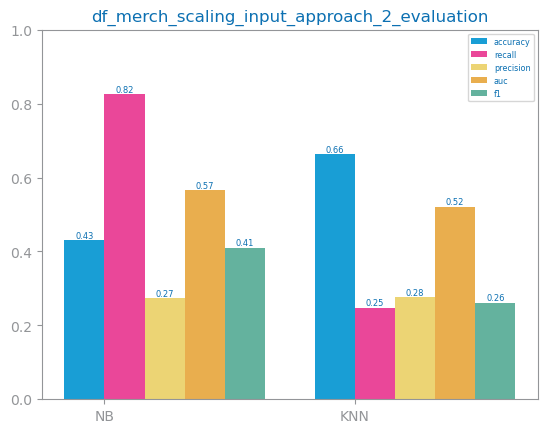

In [ ]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_unsubscribed', metric="recall")
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_2_evaluation.png")
    show()

# scaling plot

In [ ]:
if evaluate == True:

    from matplotlib.pyplot import subplots, show

    fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
    axs[0, 1].set_title("Original data")
    data.boxplot(ax=axs[0, 0])

    axs[0, 0].set_title("Z-score normalization")
    data_1.boxplot(ax=axs[0, 1])

    axs[0, 2].set_title("MinMax normalization")
    data_2.boxplot(ax=axs[0, 2])
    show()

# Approach uplift comparison

## uplift df

In [ ]:
if evaluate ==True:

    algorithms = ['Naive Bayes', 'KNN']

    # Create DataFrames for eval_1 and eval_2
    df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
    df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

    # Calculate uplift
    df_uplift = df_eval_2 - df_eval_1



    # Combine everything into one DataFrame (without misalignment issues)
    comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
    comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



    # Display the DataFrame
    display(comparison_df)

# Analysis

- NB (better on approach 2): 
    - Scale1 accuracy 0.33, recall 0.87, auc 0.51
    - scale2 accuracy 0.43 recall 0.82, auc 0.56
- KNN: no significant uplifts between approaches
- overall scale 2 vs outliers treatment
    - very significant improved recall
    - significant accuracy loss


# save to csv

In [ ]:
if test_data==False:
    
    data_save=data.copy()

    # apply winning strategy
    data_save=apply_strategy_2(data_save)
        
    data_save.to_csv(f"dataset/df_msg_scaler_input.csv", index=False)

    print(data_save.columns)